In [2]:
import tiffslide as openslide
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imsave
import cv2
import imageio
from tifffile import imread

from skimage.measure import regionprops, label
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from joblib import Parallel, delayed
import pandas as pd
from umap import UMAP

/apps/jupyter/6.5.4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-19 12:13:10.478948: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-19 12:13:12.041377: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


/home/j.maragall/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/j.maragall/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/j.maragall/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/j.maragall/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinsta

UMAP Parameters:
n_neighbors: 150
min_dist: 0
n_components: 2
metric: canberra


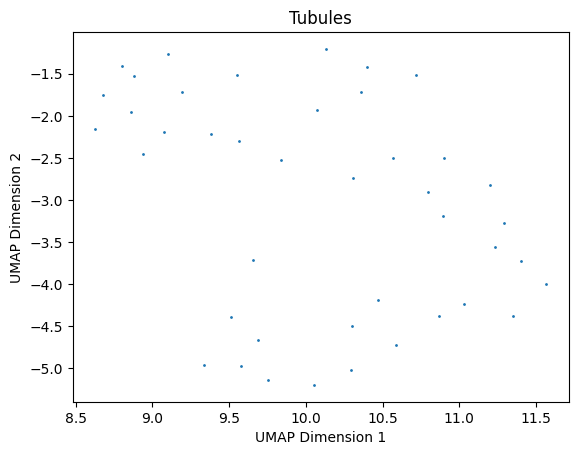

In [19]:
import pandas as pd

# Assuming df_features is loaded correctly as shown
df_features = pd.read_csv("/home/j.maragall/Pipeline_CellMapping/ae_unique_extracted_features.csv")

# Assuming df_presentation is loaded correctly and unique_id is created as shown
df_presentation = pd.read_csv('/home/j.maragall/PRESENTATION_FEATURES.csv')
df_presentation.fillna(0, inplace=True)
df_presentation['unique_id'] = df_presentation.apply(lambda x: f"ROI_{int(x['minr'])}_{int(x['maxr'])}_{int(x['minc'])}_{int(x['maxc'])}", axis=1)
unique_ids = df_presentation['unique_id'].copy()

# Create the aligned_unique_id in df_features based on existing data (if needed)
# For example, if df_features already correctly matches the unique_id pattern and just needs renaming:
df_features['aligned_unique_id'] = df_features['ROI_ID']  # Adjust if your identifier column is named differently

# Now, sort both DataFrames by their aligned unique identifiers
df_features_sorted = df_features.sort_values(by='aligned_unique_id').reset_index(drop=True)
#df_presentation_sorted = df_features_sorted.drop('labels', axis=1)
df_presentation_sorted = df_presentation.sort_values(by='unique_id').reset_index(drop=True)
#df_presentation_sorted = df_presentation_sorted.drop('presentation_labels', axis=1)


In [19]:
import numpy as np
from sklearn.manifold import LocallyLinearEmbedding

# Example matrix A with dimensions (n_samples, n_features)
features_only_features = df_features_sorted.drop(['aligned_unique_id', 'ROI_ID'], axis=1)

# Initialize LLE with desired number of components (1 for reduction to 1 column)
n_neighbors = 150  # Number of neighbors for the manifold learning, adjust as necessary
lle = LocallyLinearEmbedding(n_components=1, n_neighbors=n_neighbors, method='standard')

# Transform the matrix to a lower dimension
ae_transformed = lle.fit_transform(features_only_features)

# A_transformed is now an array with shape (n_samples, 1), where n_samples is the number of original samples
print(ae_transformed)


/home/j.maragall/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/j.maragall/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/j.maragall/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[[ 0.00267098]
 [-0.00158226]
 [ 0.00207288]
 ...
 [ 0.00210727]
 [ 0.0009111 ]
 [ 0.00262231]]


In [35]:
df_ae_transformed = pd.DataFrame(ae_transformed)

In [36]:
df_ae_transformed.head

<bound method NDFrame.head of               0
0      0.002671
1     -0.001582
2      0.002073
3     -0.000451
4      0.004410
...         ...
22275 -0.003313
22276  0.000214
22277  0.002107
22278  0.000911
22279  0.002622

[22280 rows x 1 columns]>

In [20]:
import numpy as np
import pandas as pd
from skimage.measure import label, regionprops
from skimage.io import imread
import numpy as np
import pandas as pd
from skimage.measure import label, regionprops, shannon_entropy
from skimage.io import imread
import cv2


def normalize_image(image):
    # Normalize an image to uint8
    return cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

def extract_features_from_he(image, mask):
    # Label the mask and extract features from regions
    labeled_mask = label(mask)
    regions = regionprops(labeled_mask, intensity_image=image)
    
    features = []
    for region in regions:
        intensity_values = image[region.coords[:, 0], region.coords[:, 1]]
        
        mean_intensity = np.mean(intensity_values)
        std_intensity = np.std(intensity_values)
        variance_intensity = np.var(intensity_values)
        min_intensity = np.min(intensity_values)
        max_intensity = np.max(intensity_values)
        median_intensity = np.median(intensity_values)
        contrast = max_intensity - min_intensity
        entropy = shannon_entropy(intensity_values)
        smoothness = 1 - (1 / (1 + variance_intensity))
        
        features.append([
            mean_intensity, std_intensity, variance_intensity, 
            min_intensity, max_intensity, median_intensity,
            contrast, entropy, smoothness
        ])
    
    return np.array(features)

# Load your images (placeholders for actual paths)
dapi_mask = imread('/home/j.maragall/Pipeline_CellMapping/R2_DAPI_cleaned_mask.tif')
he_image = imread( "/home/j.maragall/j.maragall/Replication2 _DAPImapping/transformed_image.tif")
# Normalize your images if needed
normalized_dapi_mask = normalize_image(dapi_mask)
normalized_he_image = normalize_image(he_image)

# Extract features
features = extract_features_from_he(normalized_he_image, normalized_dapi_mask)

# Convert to DataFrame for easy handling
HE_features_df = pd.DataFrame(features, columns=[
    'Mean_Intensity', 'Std_Intensity', 'Variance_Intensity', 
    'Min_Intensity', 'Max_Intensity', 'Median_Intensity',
    'Contrast', 'Entropy', 'Smoothness'
])

print(HE_features_df.head())


HE_features_df.shape

   Mean_Intensity  Std_Intensity  Variance_Intensity  Min_Intensity  \
0      184.940252      16.038855          257.244858          141.0   
1      164.188889      57.181290         3269.699877           20.0   
2       85.971698      36.735445         1349.492910           21.0   
3      157.088710      57.171739         3268.607722           47.0   
4      116.422392      49.771664         2477.218532           29.0   

   Max_Intensity  Median_Intensity  Contrast   Entropy  Smoothness  
0          215.0             188.0      74.0  5.634200    0.996128  
1          235.0             182.0     215.0  6.922230    0.999694  
2          193.0              78.5     172.0  6.678648    0.999260  
3          236.0             153.5     189.0  6.751323    0.999694  
4          227.0             112.5     198.0  7.211587    0.999596  


(22280, 9)

In [23]:
HE_features_df.to_csv('HE_9fs.csv', index=False)

In [20]:
# Assuming 'df_features' and 'df_presentation' are already loaded with 'unique_id' and 'aligned_unique_id' properly set

# Sort both DataFrames by their unique identifiers
df_features_sorted = df_features.sort_values(by='aligned_unique_id').reset_index(drop=True)
df_presentation_sorted = df_presentation.sort_values(by='unique_id').reset_index(drop=True)

# Ensure features only in datasets and apply UMAP
features_only_features = df_features_sorted.drop(['aligned_unique_id', 'ROI_ID'], axis=1)
features_only_presentation = df_presentation_sorted.drop(['unique_id'], axis=1).fillna(0)


In [21]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Impute all NaN values with 0
df_ae_transformed.fillna(0, inplace=True)

# Create a scaler object
scaler = MinMaxScaler()

# Fit and transform the data
df_ae_transformed = pd.DataFrame(scaler.fit_transform(df_ae_transformed))


/home/j.maragall/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/j.maragall/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/j.maragall/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/j.maragall/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinsta

In [38]:
df_ae_transformed.head

<bound method NDFrame.head of               0
0      0.742504
1      0.684280
2      0.734316
3      0.699771
4      0.766316
...         ...
22275  0.660592
22276  0.708865
22277  0.734787
22278  0.718412
22279  0.741837

[22280 rows x 1 columns]>

In [7]:
df_ae_transformed = pd.read_csv("/home/j.maragall/Pipeline_CellMapping/ae_vector.csv")

In [38]:
df_ae_transformed.columns = ['AE_Val']

In [32]:

import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from umap import UMAP
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Example alpha value
alpha = .7638

# Assuming 'scaled_val' comes from a DataFrame and 'Val' is the column to use
scaled_val = (df_ae_transformed['Val'] * alpha).fillna(0)

# If scaled_val is already calculated but in DataFrame format
# scaled_val = scaled_val.squeeze()  # Convert DataFrame with single column to Series

# Multiply features_only_presentation with the scaled 'Val'
weighted_combined = features_only_presentation.mul(scaled_val, axis=0)


umap_model_features = UMAP(n_neighbors=7, min_dist=0, n_components=2, random_state=42, metric="canberra")
umap_model_presentation = UMAP(n_neighbors=7, min_dist=0, n_components=2, random_state=42, metric="canberra")

weighted_embedding_features = umap_model_features.fit_transform(weighted_combined)
deep_embedding_presentation = umap_model_presentation.fit_transform(features_only_presentation)

/home/j.maragall/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/j.maragall/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/j.maragall/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/j.maragall/.local/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f

In [39]:
df_ae_transformed

,AE_Val
0,0.742504
1,0.684280
2,0.734316
3,0.699771
4,0.766316
...,...
22275,0.660592
22276,0.708865
22277,0.734787
22278,0.718412


UMAP Parameters:
n_neighbors: 150
min_dist: 0
n_components: 2
metric: canberra


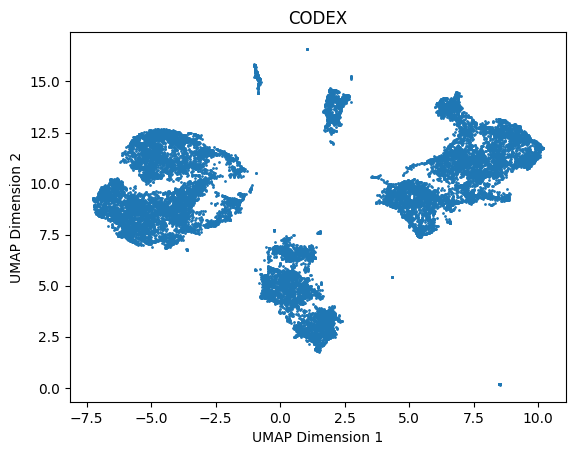

In [36]:
#results_df.to_csv('Contrast_Weighted_CODEX_.csv', index=False)

# Plot the results
plt.scatter(deep_embedding_presentation[:, 0], deep_embedding_presentation[:, 1], s=1)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('CODEX')

# Print the parameters
print("UMAP Parameters:")
print(f"n_neighbors: {umap_model.n_neighbors}")
print(f"min_dist: {umap_model.min_dist}")
print(f"n_components: {umap_model.n_components}")
print(f"metric: {umap_model.metric}")

plt.show()



In [142]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from umap import UMAP
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import numpy as np

# Example DataFrame df_ae_transformed and features_only_presentation
# Ensure df_ae_transformed['Val'] and features_only_presentation are defined

# Define a range of alpha values to iterate over
alpha_values = np.linspace(0.1, 1.0, 42)  # for example, from 0.1 to 1.0 in 10 steps

# List to store the results
results = []

# Loop over each alpha value
for alpha in alpha_values:
    # Scale 'Val' by current alpha
    scaled_val = (df_ae_transformed['Val'] * alpha).fillna(0)

    # Multiply features_only_presentation with the scaled 'Val'
    weighted_combined = features_only_presentation.mul(scaled_val, axis=0)

    # UMAP models for embedding
    umap_model_features = UMAP(n_neighbors=7, min_dist=0, n_components=2, random_state=42, metric="canberra")
    umap_model_presentation = UMAP(n_neighbors=7, min_dist=0, n_components=2, random_state=42, metric="canberra")

    # Compute embeddings
    weighted_embedding_features = umap_model_features.fit_transform(weighted_combined)
    deep_embedding_presentation = umap_model_presentation.fit_transform(features_only_presentation)

    # Calculate cosine similarity
    similarity = cosine_similarity(weighted_embedding_features, deep_embedding_presentation)
    
    # Store alpha and the first value of cosine similarity matrix (assuming comparison of the whole set to itself)
    results.append({'alpha': alpha, 'cosine_similarity': similarity[0][0]})

# Create a DataFrame to hold the results
results_df = pd.DataFrame(results)

# Print the results DataFrame
print(results_df)


/home/j.maragall/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/j.maragall/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/j.maragall/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/j.maragall/.local/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f

       alpha  cosine_similarity
0   0.100000           0.378633
1   0.121951           0.079460
2   0.143902           0.682033
3   0.165854           0.591447
4   0.187805           0.475219
5   0.209756           0.610897
6   0.231707           0.671062
7   0.253659           0.631857
8   0.275610           0.621679
9   0.297561           0.500595
10  0.319512           0.237778
11  0.341463           0.715261
12  0.363415           0.601899
13  0.385366           0.641874
14  0.407317           0.667094
15  0.429268           0.613887
16  0.451220           0.667486
17  0.473171           0.654322
18  0.495122          -0.040011
19  0.517073           0.603504
20  0.539024           0.650001
21  0.560976           0.544225
22  0.582927           0.645132
23  0.604878           0.713545
24  0.626829           0.647269
25  0.648780           0.246778
26  0.670732          -0.034802
27  0.692683           0.610021
28  0.714634           0.027424
29  0.736585           0.673561
30  0.75

,alpha,cosine_similarity
0,0.100000,0.378633
1,0.121951,0.079460
2,0.143902,0.682033
3,0.165854,0.591447
4,0.187805,0.475219
5,0.209756,0.610897
6,0.231707,0.671062
7,0.253659,0.631857
8,0.275610,0.621679
9,0.297561,0.500595


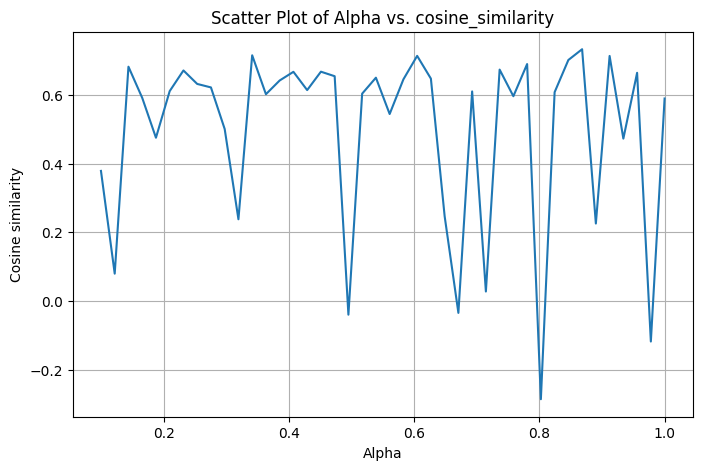

In [152]:
# Plotting
plt.figure(figsize=(8, 5))
plt.plot(results_df['alpha'], results_df['cosine_similarity'])
plt.title('Scatter Plot of Alpha vs. cosine_similarity')
plt.xlabel('Alpha')
plt.ylabel('Cosine similarity')
plt.grid(True)
plt.show()

In [138]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from umap import UMAP
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score


umap_model_features = UMAP(n_neighbors=7, min_dist=0, n_components=2, random_state=42, metric="canberra")
umap_model_presentation = UMAP(n_neighbors=7, min_dist=0, n_components=2, random_state=42, metric="canberra")

weighted_embedding_features = umap_model_features.fit_transform(weighted_combined)
deep_embedding_presentation = umap_model_presentation.fit_transform(features_only_presentation)

/home/j.maragall/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/j.maragall/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/j.maragall/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/j.maragall/.local/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f

In [133]:
df_weighted = pd.DataFrame(weighted_embedding_features)
df_presentation = pd.DataFrame(deep_embedding_presentation)

In [134]:
df_weighted.head

<bound method NDFrame.head of                0          1
0      14.124371  12.424570
1       6.620988  13.844890
2       9.590178   3.602582
3      10.390535   4.163884
4       1.047682   9.754580
...          ...        ...
22275  12.630604  12.574650
22276  13.701935  10.045114
22277  14.745836  10.793130
22278  15.304808  11.960469
22279   4.011459   7.714523

[22280 rows x 2 columns]>

In [135]:
df_presentation.head

<bound method NDFrame.head of               0          1
0     -4.137939  11.958049
1      2.071385  12.931609
2      1.283287   2.943742
3      0.640724   2.978132
4      8.713970  10.474080
...         ...        ...
22275 -2.882764  11.490839
22276 -4.417958   8.664707
22277 -6.195876  10.015882
22278 -4.972098  11.926049
22279  5.324221   8.463024

[22280 rows x 2 columns]>

In [136]:
# Calculate cosine similarity
similarity = cosine_similarity(df_weighted, df_presentation)

print("Cosine Similarity:", similarity[0][0])

Cosine Similarity: 0.37863347


In [109]:
df_weighted_stacked = df_weighted.stack()

In [110]:
df_presentation_stacked = df_presentation.stack()

In [118]:
from sklearn.metrics.pairwise import cosine_similarity

In [120]:
similarity = cosine_similarity(df_weighted, df_presentation_stacked)

print("Cosine Similarity:", similarity[0][0])

Cosine Similarity: 0.97640884


In [111]:
# Calculate ARI and NMI scores with the aligned and sorted data
nmi_score = normalized_mutual_info_score(df_weighted_stacked, df_presentation_stacked, average_method='arithmetic')
print(f"Normalized Mutual Information (NMI) score: {nmi_score}")

Normalized Mutual Information (NMI) score: 0.9998866415247304


/home/j.maragall/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/j.maragall/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/j.maragall/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/j.maragall/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_spar

In [99]:
df_weighted_stacked.head

<bound method NDFrame.head of 0      0    14.124371
       1    12.424570
1      0     6.620988
       1    13.844890
2      0     9.590178
              ...    
22277  1    10.793130
22278  0    15.304808
       1    11.960469
22279  0     4.011459
       1     7.714523
Length: 44560, dtype: float32>

In [97]:
df_presentation_stacked.head

<bound method NDFrame.head of 0      0    -4.137939
       1    11.958049
1      0     2.071385
       1    12.931609
2      0     1.283287
              ...    
22277  1    10.015882
22278  0    -4.972098
       1    11.926049
22279  0     5.324221
       1     8.463024
Length: 44560, dtype: float32>

In [156]:
import numpy as np
import pandas as pd
from skimage.measure import label, regionprops, shannon_entropy
from skimage.io import imread
import cv2

def normalize_image(image):
    # Normalize an image to uint8
    return cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

def extract_features_from_he(image, mask):
    # Label the mask and extract features from regions
    labeled_mask = label(mask)
    regions = regionprops(labeled_mask, intensity_image=image)
    
    features = []
    for region in regions:
        minr, minc, maxr, maxc = region.bbox
        intensity_values = image[region.coords[:, 0], region.coords[:, 1]]
        
        mean_intensity = np.mean(intensity_values)
        std_intensity = np.std(intensity_values)
        variance_intensity = np.var(intensity_values)
        min_intensity = np.min(intensity_values)
        max_intensity = np.max(intensity_values)
        median_intensity = np.median(intensity_values)
        contrast = max_intensity - min_intensity
        entropy = shannon_entropy(intensity_values)
        smoothness = 1 - (1 / (1 + variance_intensity))
        
        # Append new features and bbox information
        features.append([
            mean_intensity, std_intensity, variance_intensity, 
            min_intensity, max_intensity, median_intensity,
            contrast, entropy, smoothness,
            f"{minr}_{maxr}_{minc}_{maxc}"  # ROI_ID
        ])
    
    return np.array(features)

# Load your images (placeholders for actual paths)
dapi_mask = imread('/home/j.maragall/Pipeline_CellMapping/R2_DAPI_cleaned_mask.tif')
he_image = imread("/blue/pinaki.sarder/j.maragall/transformed_image.tif")
# Normalize your images if needed
normalized_dapi_mask = normalize_image(dapi_mask)
normalized_he_image = normalize_image(he_image)

# Extract features
features = extract_features_from_he(normalized_he_image, normalized_dapi_mask)

# Convert to DataFrame for easy handling
HE_features_df = pd.DataFrame(features, columns=[
    'Mean_Intensity', 'Std_Intensity', 'Variance_Intensity', 
    'Min_Intensity', 'Max_Intensity', 'Median_Intensity',
    'Contrast', 'Entropy', 'Smoothness', 'ROI_ID'
])

print(HE_features_df.head())
print(HE_features_df.shape)

       Mean_Intensity       Std_Intensity  Variance_Intensity Min_Intensity  \
0  184.94025157232704   16.03885462863064   257.2448577983466           141   
1   164.1888888888889  57.181289566983445    3269.69987654321            20   
2   85.97169811320755   36.73544486861467   1349.492909695028            21   
3  157.08870967741936    57.1717388400159   3268.607721990982            47   
4  116.42239185750635  49.771663943288026  2477.2185316835976            29   

  Max_Intensity Median_Intensity Contrast            Entropy  \
0           215            188.0       74  5.634200151613818   
1           235            182.0      215  6.922229759113534   
2           193             78.5      172  6.678647980780808   
3           236            153.5      189  6.751322688295277   
4           227            112.5      198  7.211586716324022   

           Smoothness           ROI_ID  
0  0.9961277060518244   3_22_1162_1173  
1  0.9996942550408945   5_24_4557_4567  
2  0.999259529618

In [157]:
HE_features_df.to_csv('HE_9fs.csv', index=False)

In [159]:
results_df.to_csv('AE_Weighted_CODEX_.csv', index=False)